In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)

### 데이터 불러오는 방법

Redis를 사용해서 캐싱된 데이터를 불러오기  
캐싱된 데이터는 모두 Pandas DataFrame의 형식을 스트링값으로 변형시킨 후에 저장한 값들이다.

In [112]:
import redis

cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

KOSPI_INDEX = 'I.001_INDEX'

KOSPI_TICKERS = 'KOSPI_TICKERS'
KOSDAQ_TICKERS = 'KOSDAQ_TICKERS'

KOSPI_OHLCV = 'KOSPI_OHLCV'
KOSDAQ_OHLCV = 'KOSDAQ_OHLCV'

KOSPI_VOL = 'KOSPI_VOL'
KOSDAQ_VOL = 'KOSDAQ_VOL'

# 코스피, 코스닥 전체 종목 코드 만들기
kp_tickers = [ticker.decode() for ticker in r.lrange(KOSPI_TICKERS, 0 ,-1)]
kd_tickers = [ticker.decode() for ticker in r.lrange(KOSDAQ_TICKERS, 0 ,-1)]
tickers = kp_tickers + kd_tickers

# Risk란?

리스크(risk)란 위험을 뜻한다. 주식 시장에서 성공은 리스크를 얼마나 이해하나에 달렸다.

시장에서 이기기 위해서는 어떻게 투자를 하는게 맞을까?

## 1. 주식은 복리로 움직인다

In [3]:
# 50% 상승, 50% 하락
return_value = (1 + 0.5) * (1 - 0.5) -1
print(return_value)

# 50% 하락, 50% 하락
return_value = (1 - 0.5) * (1 - 0.5) - 1
print(return_value)

# 재귀함수 만들기
def capital_with_loss(loss, repeat_num):
    if repeat_num == 0:
        return 1
    else:
        return (1 - loss) * capital_with_loss(loss, repeat_num - 1)

# 50% 10번 연속 하락
return_value = capital_with_loss(0.5, 10) - 1
print(return_value)

# 10% 10번 연속 하락
return_value = capital_with_loss(0.1, 10) - 1
print(return_value)
# 다른 계산 방법
return_value = (0.9) ** 10 - 1
print(return_value)

-0.25
-0.75
-0.9990234375
-0.6513215598999998
-0.6513215599


## 2. 손익 비대칭성의 원리

1.0


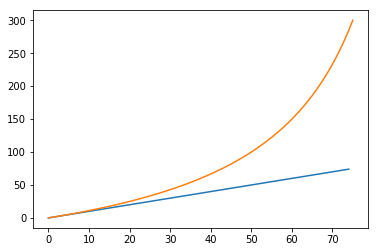

In [4]:
# 손실 50%에서 본전이 되려면 얻어야 하는 수익률은?
needed_profit = (1 - (1 - 0.5)) / (1 - 0.5)
print(needed_profit)

def get_needed_profit(loss):
    return (1 - (1 - loss)) / (1 - loss)

# 손실 x%에 필요한 y%의 수익률 테이블로 그리기
needed_profits = []
for i in range(100):
    needed_profit = get_needed_profit(i / 100) * 100
    needed_profits.append(needed_profit)
    
profit_df = pd.DataFrame(needed_profits)
plt.plot([i for i in range(75)])
profit_df[0].loc[0:75].plot()
plt.show()

## 3. 변동성 손실

In [5]:
# 10% 상승, 10% 하락 수익률
return_value = (1 + 0.1) * (1 - 0.1) - 1
print(return_value)

# 20% 상승, 20% 하락 수익률
return_value = 1.2 * 0.8 - 1
print(return_value)

# 50% 상승, 50% 하락 수익률
return_value = 1.5 * 0.5 - 1
print(return_value)

# 30% 상승, 20% 하락 vs. 20% 상승, 10% 하락
return_value_1 = 1.3 * 0.8 - 1
return_value_2 = 1.2 * 0.9 - 1
print(return_value_1, return_value_2)

-0.009999999999999898
-0.040000000000000036
-0.25
0.040000000000000036 0.08000000000000007


### 변동성을 계산한 후 각 종목의 평균 수익률 확인하기

In [6]:
tickers[0]

'000020'

In [7]:
tickers[1]

'000030'

In [8]:
df_1 = pd.read_msgpack(r.get(tickers[0] + '_FULL_OHLCV'))
df_2 = pd.read_msgpack(r.get(tickers[1] + '_FULL_OHLCV'))

In [9]:
prc_1 = df_1['adj_prc']
prc_2 = df_2['adj_prc']

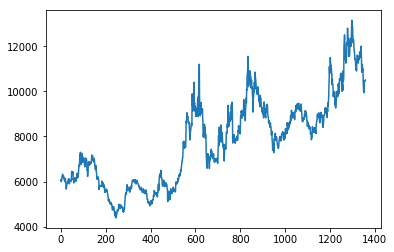

In [10]:
prc_1.plot()
plt.show()

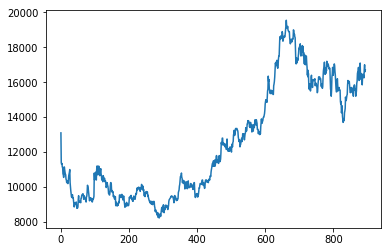

In [11]:
prc_2.plot()
plt.show()

In [12]:
std_1 = prc_1.std()
std_2 = prc_2.std()

print(std_1, std_2)

1948.4376857944642 3198.2404817173974


In [13]:
ret_1 = prc_1.pct_change() + 1
ret_1.fillna(1, inplace=True)

val_1 = 1
values = []

for i in range(len(ret_1)):
    val_1 = val_1 * ret_1[i]
    values.append(val_1)
    
profit_1 = (values[-1] - values[0]) / values[0]
print(profit_1)

0.7241379310344735


In [14]:
def total_profit(ticker):
    df = pd.read_msgpack(r.get(ticker + '_FULL_OHLCV'))
    prc = df['adj_prc']
    
    ret = prc.pct_change() + 1
    ret.fillna(1, inplace=True)
    
    std = ret.rolling(200).std()
    
    plt.rcParams["figure.figsize"] = (12, 3)
    prc.plot()
    plt.show()
    
    ret.plot(color='pink')
    plt.show()
    
    std.plot(color='cyan')
    plt.show()

    val = 1
    values = []

    for i in range(len(ret)):
        val = val * ret[i]
        values.append(val)

    profit = (values[-1] - values[0]) / values[0]
    
    print('Standard Deviation: {}'.format(ret.std()))
    print('Mean Return: {}'.format(ret.mean() - 1))
    print('Total Profit: {}'.format(profit))

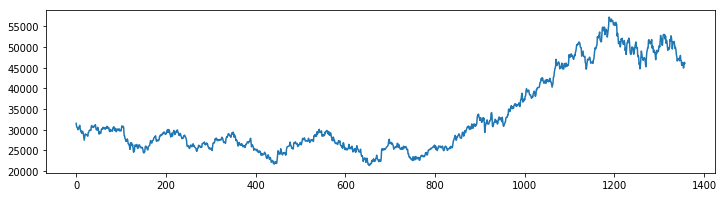

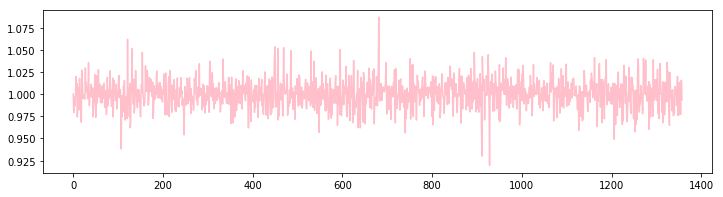

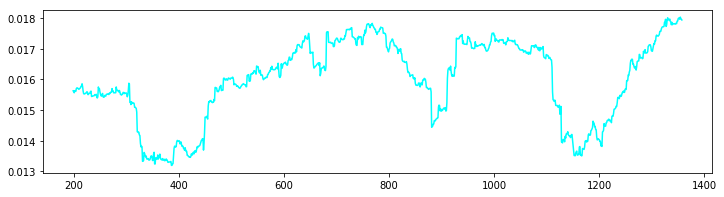

Standard Deviation: 0.016133891104956187
Mean Return: 0.00040839007099791047
Total Profit: 0.45939086294416454


In [15]:
total_profit('005930')

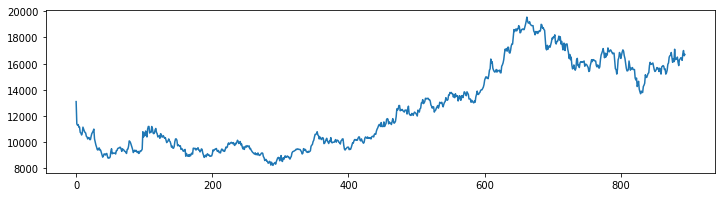

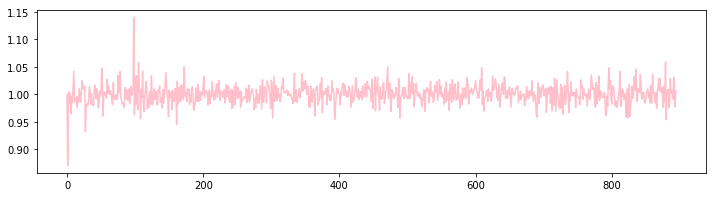

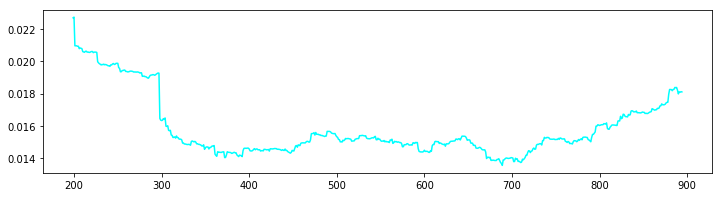

Standard Deviation: 0.017481734710303613
Mean Return: 0.00042394718065641435
Total Profit: 0.2748091603053384


In [16]:
total_profit('000030')

# 변동성을 줄이는 방법

#### 1. 분산투자
#### 2. 여러 자산군 투자
#### 3. 장세에 따른 비중 조절

Profit: 0.72


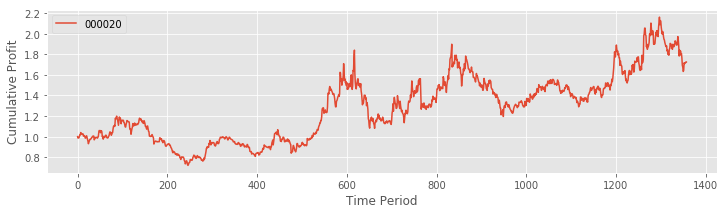

In [17]:
# 수익률 곡선 그리는 방법
df = pd.read_msgpack(r.get(tickers[0] + '_FULL_OHLCV'))
prc = df['adj_prc']
ret = (prc.pct_change() + 1).fillna(1)
yc = ret.cumprod() # yield curve

import matplotlib.pyplot as plt
plt.style.use('ggplot') # https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html

print('Profit: {}'.format(round(yc.iloc[-1] - yc.iloc[0], 2)))

yc.plot()
plt.xlabel('Time Period')
plt.ylabel('Cumulative Profit')
plt.legend([tickers[0]]);
plt.show()

In [18]:
ret.head()

0    1.000000
1    0.985222
2    1.003333
3    1.000000
4    1.014950
Name: adj_prc, dtype: float64

Profit: 0.72


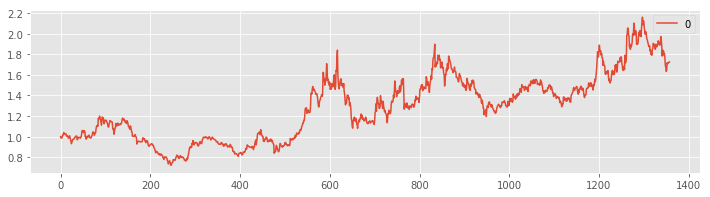

In [22]:
## 수익률 계산이 제대로 됐는지 확인하기
value = 1
value_history = []

for i in range(len(ret)):
    value = value * ret[i]
    value_history.append(value)

yield_curve = pd.DataFrame(value_history)

##### === ret = (prc.pct_change() + 1).fillna(1), yc = ret.cumprod() # yield curve

print('Profit: {}'.format(round((value_history[-1] - value_history[0]) / value_history[0], 2)))

yield_curve.plot()
plt.show()

In [23]:
# 2개 조합, 3개 조합, ... , 100개 조합까지 테스팅
# 수익률이 좋아지는지 안 좋아지는지 확인하기
# 전략의 좋고 좋음을 판단하기 위해서 Sharpe Ratio, Information Ratio를 활용
# Sharpe Ratio는 무위험 수익률 대비 포트폴리오의 성과를 나타내는 지표
# Information Ratio는 벤치마크(지수) 수익률 대비 포트폴리오의 성과를 나타내는 지표

### IR (Information Return) = E[Excess Return] / Std(Excess Return)
### ER (Excess Return) = Ret(port) - Ret(bm), ( port = portfolio, bm = benchmark )

In [104]:
# 우선 벤치마크 데이터를 불러온다
KOSPI_INDEX = 'I.001_INDEX'

bm = pd.read_msgpack(r.get(KOSPI_INDEX))
bm = pd.DataFrame(bm['cls_prc'])
bm['Return'] = bm['cls_prc'].pct_change().fillna(0)
bm['Yield Curve'] = (bm['Return'] + 1).cumprod()

In [82]:
plt.rcParams["figure.figsize"] = (12, 3)

Portfolio Profit: -0.054899606816613544


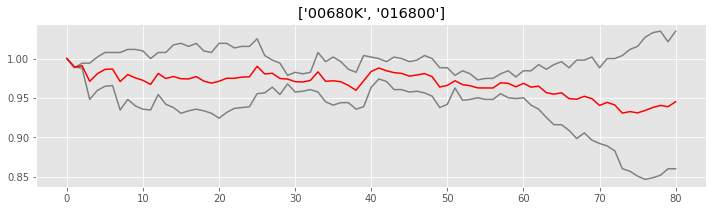

Portfolio Profit: -0.010610404711003829


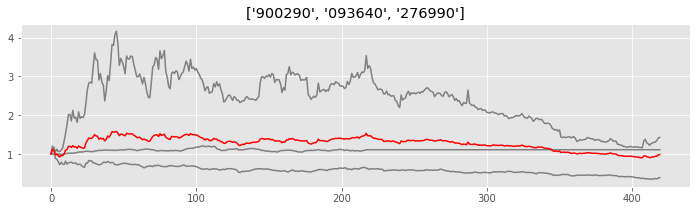

Portfolio Profit: 0.771661233526463


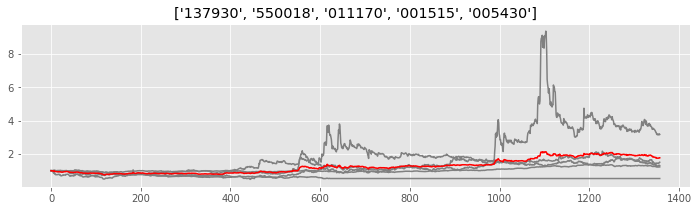

Portfolio Profit: 0.6604875267432164


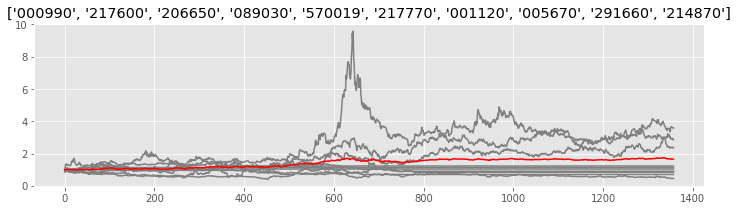

In [108]:
# 첫 2, 3, 5, 10개짜리 포트폴리오 같이 제작

for i in [2, 3, 5, 10]:
    port = list(np.random.choice(tickers, i)) # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html

    prc = pd.DataFrame()
    for ticker in port:
        df = pd.read_msgpack(r.get(ticker + '_OHLCV'))
        prc[ticker] = df['adj_prc']

    ret = (prc.pct_change() + 1).fillna(1)
    yc = ret.cumprod()
    
    rt = prc.pct_change().fillna(0)
    port_ret = (rt * ( [1/i] * i )).T.sum()
    port_yc = (port_ret + 1).fillna(1).cumprod()
    
    print('Portfolio Profit: {}'.format(port_yc.iloc[-1] - port_yc.iloc[0]))

    for colname in yc:
        yc[colname].plot(color='gray')
    port_yc.plot(color='red')
    plt.title(port)
    plt.show()

Portfolio Return: 0.6604875267432164, Benchmark Return: 0.12284968736153168
Information Ratio: 1.8457884285793626


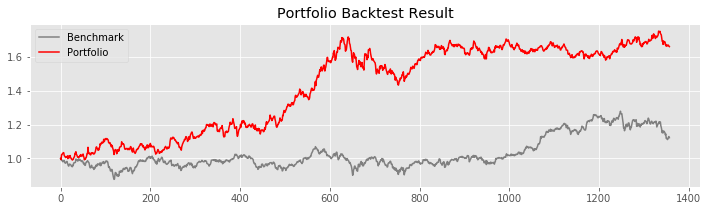

In [117]:
backtest = pd.DataFrame()
backtest['Portfolio'] = port_yc
backtest['Benchmark'] = bm['Yield Curve']

# Information Ratio
backtest['Excess Return'] = backtest['Portfolio'] - backtest['Benchmark']
ir = backtest['Excess Return'].mean() / backtest['Excess Return'].std()

port_ret = backtest['Portfolio'].iloc[-1] - backtest['Portfolio'].iloc[0]
bm_ret = backtest['Benchmark'].iloc[-1] - backtest['Benchmark'].iloc[0]
print('Portfolio Return: {}, Benchmark Return: {}'.format(port_ret, bm_ret))
print('Information Ratio: {}'.format(ir))

backtest['Benchmark'].plot(color='gray')
backtest['Portfolio'].plot(color='red')
plt.legend(['Benchmark', 'Portfolio'])
plt.title('Portfolio Backtest Result')
plt.show()

### 통계를 사용하여 가설 검증하는 방법

Population을 모르는 상태에서 완벽한 가설 검증을 하지는 못하지만, 최대한 체계적으로 접근하여 문제를 분석하여야 한다.

Reference: http://onlinestatbook.com/2/tests_of_means/difference_means.html

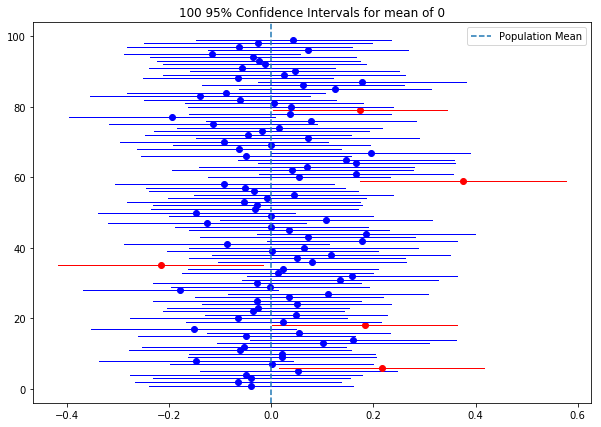

In [3]:
from scipy import stats

# https://www.quantopian.com/lectures/confidence-intervals

np.random.seed(8309)
n = 100 # number of samples to take
samples = [np.random.normal(loc=0, scale=1, size=100) for _ in range(n)] # loc: 평균, scale: 표준편차

fig, ax = plt.subplots(figsize=(10, 7))
for i in np.arange(1, n, 1):
    sample_mean = np.mean(samples[i])  # calculate sample mean
    se = stats.sem(samples[i])  # calculate sample standard error, SE = np.std(samples[i]) / np.sqrt(len(samples[i]))
    h = se * stats.t.ppf((1 + 0.95) / 2, len(samples[i]) - 1) # calculate t; 2nd param is d.o.f. 
    sample_ci = [sample_mean - h, sample_mean + h]
    if ((sample_ci[0] <= 0) and (0 <= sample_ci[1])):
        plt.plot((sample_ci[0], sample_ci[1]), (i, i), color='blue', linewidth=1)
        plt.plot(np.mean(samples[i]), i, 'bo')
    else:
        plt.plot((sample_ci[0], sample_ci[1]), (i, i), color='red', linewidth=1)
        plt.plot(np.mean(samples[i]), i, 'ro')
plt.axvline(x=0, ymin=0, ymax=1, linestyle='--', label = 'Population Mean')
plt.legend(loc='best')
plt.title('100 95% Confidence Intervals for mean of 0')
plt.show()

In [3]:
# 코스피, 코스닥 전체 종목 종가 데이터 모두 합쳐진거 불러오기
kp_ohlcv = pd.read_msgpack(r.get('KOSPI_OHLCV'))
kd_ohlcv = pd.read_msgpack(r.get('KOSDAQ_OHLCV'))

ohlcv = pd.concat([kp_ohlcv, kd_ohlcv], axis=1)
tickers = list(ohlcv.columns)

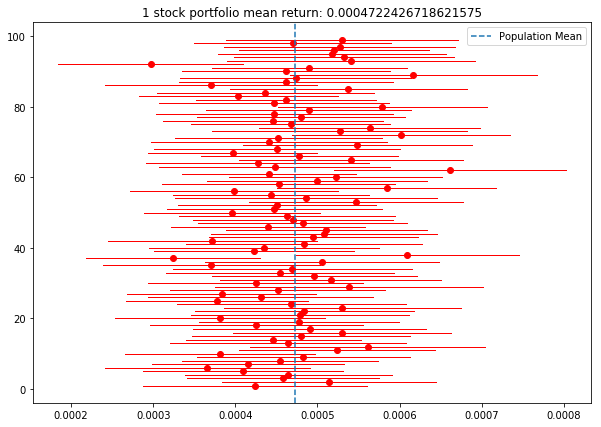

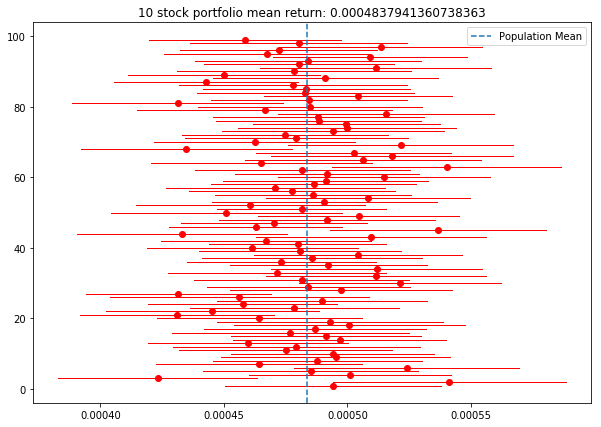

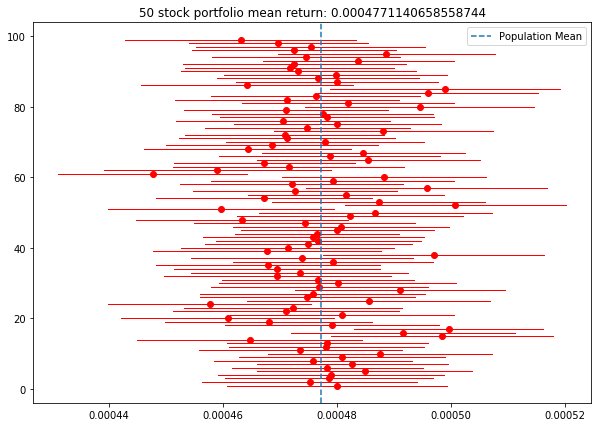

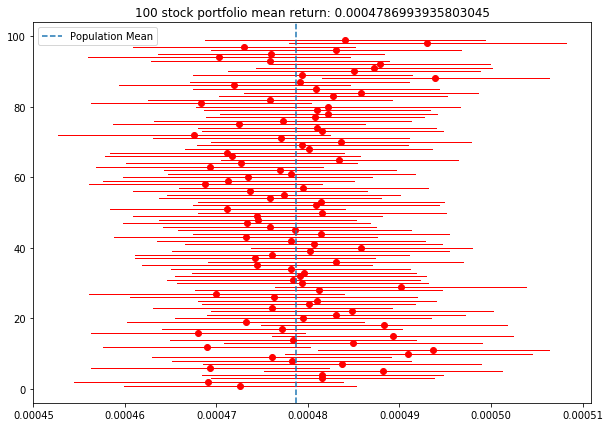

In [6]:
# 1 종목 포트폴리오와 2, 5, 10 종목 포트폴리오 비교

for stock_num in [1, 10, 50, 100]:
    port_num = 100
    sample_num = 100
    samples = [[np.random.choice(tickers, stock_num) for _ in range(port_num)] for __ in range(sample_num)]
    
    fig, ax = plt.subplots(figsize=(10, 7))

    sample_means = []
    
    for i in range(1, len(samples), 1):
        port_returns = []
        for port in samples[i]:
            port_return = ohlcv[port].pct_change().fillna(0).mean().mean()
            port_returns.append(port_return)
        sample_mean = np.mean(port_returns)
        sample_means.append(sample_mean)
        se = stats.sem(port_returns)
        h = se * stats.t.ppf((1 + 0.95) / 2, len(port_returns) - 1)
        sample_ci = [sample_mean - h, sample_mean + h]
        if ((sample_ci[0] <= 0) and (0 <= sample_ci[1])):
            plt.plot((sample_ci[0], sample_ci[1]), (i, i), color='blue', linewidth=1)
            plt.plot(sample_mean, i, 'bo')
        else:
            plt.plot((sample_ci[0], sample_ci[1]), (i, i), color='red', linewidth=1)
            plt.plot(sample_mean, i, 'ro')
            
    plt.axvline(x=np.mean(sample_means), ymin=0, ymax=1, linestyle='--', label = 'Population Mean')
    plt.legend(loc='best')
    plt.title('{} stock portfolio mean return: {}'.format(stock_num, np.mean(sample_means)))
    plt.show()

### 여러 자산군 투자

보통 채권과 주식은 장기적으로는 상승하고 단기적으로는 반대로 움직여서 두 자산군에 함께 투자한다면, 안정적인 수익률 곡선을 그릴 수 있다. 하지만, 우리는 채권 투자보다는 현금을 사용하여 리스크를 관리한다. 결국, 리스크를 관리한 포트폴리오는 주식과 현금 이렇게 2가지 자산군으로 구성되어 있을 것이다. 현금음 수익률은 없지만, 하락장에서 손실을 줄여주는 중요한 역할을 한다.

In [17]:
# 코스피로 테스트
KOSPI_INDEX = 'I.001_INDEX'

bm = pd.read_msgpack(r.get(KOSPI_INDEX))
bm = pd.DataFrame(bm[['date', 'cls_prc']])
bm.index = pd.to_datetime(bm['date'])
bm.drop(['date'], axis=1, inplace=True)
bm['Return'] = bm['cls_prc'].pct_change().fillna(0)
bm['Yield Curve'] = (bm['Return'] + 1).cumprod()

In [40]:
# 현금 수익률을 0이라고 보고 테스트해본다.
# Claude Shannon은 주식 50%에 현금 50%로 투자를 해서 한달에 한번씩 rebalancing하여 큰 돈을 벌었다
# 같은 전략을 사용하여 수익률을 계산해본다.
 
# 일별 수익률을 얼별 수익률로 바꾼다.
# resample을 해야하는데 위에서 index를 datetime으로 바꿔준다
bm_m = pd.DataFrame(bm['cls_prc'].resample('M').last())# 매월 마지막 지수를 가지고 온다
bm_m['Return'] = bm_m['cls_prc'].pct_change().fillna(0)
bm_m['Yield Curve'] = (bm_m['Return'] + 1).cumprod()

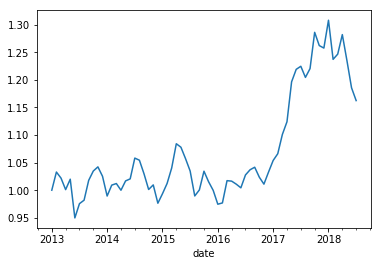

In [41]:
bm_m['Yield Curve'].plot()
plt.show()

In [42]:
# 현금에 50%, 주식에 50%를 투자한다면, 주식의 수익률에 0.5를 곱하면 된다
bm_m['50-50 Return'] = bm_m['Return'] * 0.5
bm_m['50-50 Yield Curve'] = (bm_m['50-50 Return'] + 1).cumprod()

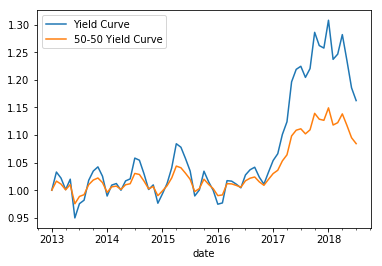

In [43]:
bm_m[['Yield Curve', '50-50 Yield Curve']].plot()
plt.show()

In [44]:
# 현금에 80%, 주식에 20%를 투자한다면, 주식의 수익률에 0.2를 곱하면 된다
bm_m['80-20 Return'] = bm_m['Return'] * 0.2
bm_m['80-20 Yield Curve'] = (bm_m['80-20 Return'] + 1).cumprod()

KOSPI 수익률: 0.16243106313138966
현금 50 주식 50 수익률: 0.08439661137790488
현금 80 주식 20 수익률: 0.0343711273538716


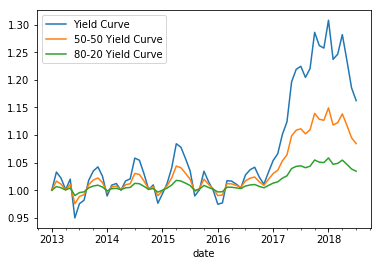

In [45]:
print('KOSPI 수익률: {}'.format(bm_m['Yield Curve'].iloc[-1] - bm_m['Yield Curve'].iloc[0]))
print('현금 50 주식 50 수익률: {}'.format(bm_m['50-50 Yield Curve'].iloc[-1] - bm_m['50-50 Yield Curve'].iloc[0]))
print('현금 80 주식 20 수익률: {}'.format(bm_m['80-20 Yield Curve'].iloc[-1] - bm_m['80-20 Yield Curve'].iloc[0]))

bm_m[['Yield Curve', '50-50 Yield Curve', '80-20 Yield Curve']].plot()
plt.show()

### MDD

수익률 외 손실의 최대치를 확인하기 위해 MDD(Maximum Drawdown)을 확인한다.

In [62]:
# MDD는 포트폴리오 수익에 대해서 구해야한다
# 전체 기간에 대한 MDD를 계산하는 것은 옳지 않지 때문에 1년을 기준으로 구한다
# rolling window를 12로 하면 된다
backtest_df = bm_m[['Yield Curve', '50-50 Yield Curve', '80-20 Yield Curve']]
roll_max_prc = backtest_df.rolling(12).max()
drawdown = backtest_df / roll_max_prc - 1.0
mdd = drawdown.rolling(12).min()

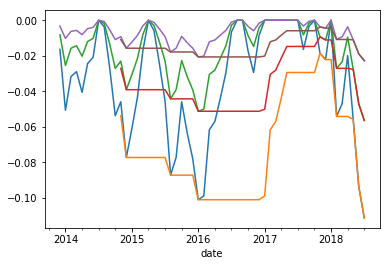

In [68]:
drawdown['Yield Curve'].plot()
mdd['Yield Curve'].plot()

drawdown['50-50 Yield Curve'].plot()
mdd['50-50 Yield Curve'].plot()

drawdown['80-20 Yield Curve'].plot()
mdd['80-20 Yield Curve'].plot()

plt.show()

### 장세에 따른 비중 조절

분산 투자와 여러 자산군에 투자하는 것만으로도 충분히 손실을 줄이고 장기적으로 시장에서 이길 수 있는 포트폴리오를 만들 수 있다. 하지만, 위에서 보면 손실은 많이 줄여도 수익률이 많이 떨어지는 것을 볼 수 있다. 이럴때는 추세 추종 전략을 사용하여, 장세에 따른 비중 조절을 하면서 손실은 줄이고 수익률은 극대화할 수 있다.

보통 투자자들은 가격이 떨어지면 사고, 가격이 오르면 팔지만, 주가에는 추세의 속성이 있기 때문에 반대로 투자하는 것이 수익률은 더 좋다.

#### 백테스팅

전략 1: 당일 주가가 최근 20일 최저가보다 낮은 경우 매수
           당일 주가가 최근 20일 최고가보다 높은 경우 매도
           
전략 2: 당일 주가가 최근 20일 최고가보다 높은 경우 매수
            당일 주가가 최근 20일 최저가보다 낮은 경우 매도

In [89]:
prc = pd.DataFrame(bm['cls_prc'])
prc['20 High'] = prc['cls_prc'].rolling(20).max()
prc['20 Low'] = prc['cls_prc'].rolling(20).min()

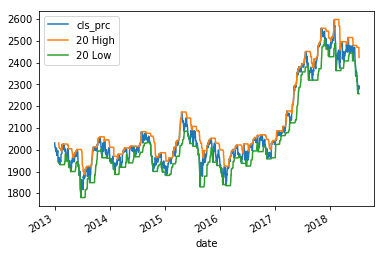

In [90]:
prc.plot()

In [99]:
# Strategy 1
prc['1 Buy'] = prc['cls_prc'] <= prc['20 Low']
prc['1 Sell'] = prc['cls_prc'] >= prc['20 High']

prc['1 Buy Price'] = np.nan
prc.loc[prc['1 Buy'] == True , '1 Buy Price'] = prc['cls_prc'] * 1.00015

prc['1 Sell Price'] = np.nan
prc.loc[prc['1 Sell'] == True , '1 Sell Price'] = prc['cls_prc'] * 1.00315

In [107]:
capital = 100000000

stock_num = 0
portfolio_value = 0

capital_history = []

for i in range(len(prc)):
    buy = prc['1 Buy'][i]
    sell = prc['1 Sell'][i]
    
    buy_price = prc['1 Buy Price'][i]
    sell_price = prc['1 Sell Price'][i]
    
    if buy == True:
        if stock_num == 0:
            # 매수
            stock_num = capital // buy_price
            portfolio_value = buy_price * stock_num
            capital = capital - portfolio_value
    elif sell == True:
        if stock_num != 0:
            # 매도
            profit = sell_price * stock_num
            capital = capital + profit
            stock_num = 0
            portfolio_value = 0
            
    total_value = capital + portfolio_value
    capital_history.append(total_value)
    
bt = pd.DataFrame()
bt['Strategy 1'] = capital_history

In [108]:
# Strategy 2
prc['2 Buy'] = prc['cls_prc'] >= prc['20 High']
prc['2 Sell'] = prc['cls_prc'] <= prc['20 Low']

prc['2 Buy Price'] = np.nan
prc.loc[prc['2 Buy'] == True , '2 Buy Price'] = prc['cls_prc'] * 1.00015

prc['2 Sell Price'] = np.nan
prc.loc[prc['2 Sell'] == True , '2 Sell Price'] = prc['cls_prc'] * 1.00315

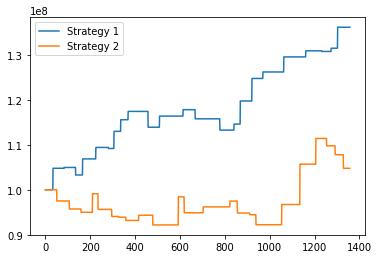

In [109]:
capital = 100000000

stock_num = 0
portfolio_value = 0

capital_history = []

for i in range(len(prc)):
    buy = prc['2 Buy'][i]
    sell = prc['2 Sell'][i]
    
    buy_price = prc['2 Buy Price'][i]
    sell_price = prc['2 Sell Price'][i]
    
    if buy == True:
        if stock_num == 0:
            # 매수
            stock_num = capital // buy_price
            portfolio_value = buy_price * stock_num
            capital = capital - portfolio_value
    elif sell == True:
        if stock_num != 0:
            # 매도
            profit = sell_price * stock_num
            capital = capital + profit
            stock_num = 0
            portfolio_value = 0
            
    total_value = capital + portfolio_value
    capital_history.append(total_value)
    
bt['Strategy 2'] = pd.DataFrame(capital_history)
bt.plot()
plt.show()

### 결론:

과거 상승장이 많을 때는 추세 추종이 잘 먹히는 것을 볼 수 있다. 하지만, 횡보장에서는 역추세를 하는 것이 수익률이 높다.

### M. Faber의 상대 강도 전략

모멘텀 전략에 관한 가장 유명한 논문.

테스팅 방법: 국내 56개 산업 데이터를 가지고, 1개월 수익률을 계산하여 수익률이 가장 좋은 산업 n개에 투자한다. 이렇게 매달 리벨런싱한다.

In [110]:
INDUSTRY_CODES = {
    '코스피 음식료품': 'I.005',
    '코스피 섬유,의복': 'I.006',
    '코스피 종이,목재': 'I.007',
    '코스피 화학': 'I.008',
    '코스피 의약품': 'I.009',
    '코스피 비금속광물': 'I.010',
    '코스피 철강및금속': 'I.011',
    '코스피 기계': 'I.012',
    '코스피 전기,전자': 'I.013',
    '코스피 의료정밀': 'I.014',
    '코스피 운수장비': 'I.015',
    '코스피 유통업': 'I.016',
    '코스피 전기가스업': 'I.017',
    '코스피 건설업': 'I.018',
    '코스피 운수창고': 'I.019',
    '코스피 통신업': 'I.020',
    '코스피 금융업': 'I.021',
    '코스피 은행': 'I.022',
    '코스피 증권': 'I.024',
    '코스피 보험': 'I.025',
    '코스피 서비스업': 'I.026',
    '코스피 제조업': 'I.027',
    '코스닥 기타서비스': 'I.212',
    '코스닥 IT종합': 'I.215',
    '코스닥 제조': 'I.224',
    '코스닥 건설': 'I.226',
    '코스닥 유통': 'I.227',
    '코스닥 운송': 'I.229',
    '코스닥 금융': 'I.231',
    '코스닥 오락, 문화': 'I.237',
    '코스닥 통신방송서비스': 'I.241',
    '코스닥 IT S/W & SVC': 'I.242',
    '코스닥 IT H/W': 'I.243',
    '코스닥 음식료,담배': 'I.256',
    '코스닥 섬유,의류': 'I.258',
    '코스닥 종이,목재': 'I.262',
    '코스닥 출판,매체복제': 'I.263',
    '코스닥 화학': 'I.265',
    '코스닥 제약': 'I.266',
    '코스닥 비금속': 'I.267',
    '코스닥 금속': 'I.268',
    '코스닥 기계,장비': 'I.270',
    '코스닥 일반전기,전자': 'I.272',
    '코스닥 의료,정밀기기': 'I.274',
    '코스닥 운송장비,부품': 'I.275',
    '코스닥 기타 제조': 'I.277',
    '코스닥 통신서비스': 'I.351',
    '코스닥 방송서비스': 'I.352',
    '코스닥 인터넷': 'I.353',
    '코스닥 디지탈컨텐츠': 'I.354',
    '코스닥 소프트웨어': 'I.355',
    '코스닥 컴퓨터서비스': 'I.356',
    '코스닥 통신장비': 'I.357',
    '코스닥 정보기기': 'I.358',
    '코스닥 반도체': 'I.359',
    '코스닥 IT부품': 'I.360'
}

In [121]:
industry = pd.DataFrame()

for index in INDUSTRY_CODES.keys():
    index_key = INDUSTRY_CODES[index] + '_INDEX'
    index_df = pd.read_msgpack(r.get(index_key))
    industry[index] = index_df['cls_prc']
    
industry.index = pd.to_datetime(index_df['date'])

In [122]:
industry_m = industry.resample('M').last()

In [164]:
# 한달 수익률 기반 모멘텀 전략
ind_m_ret = industry_m.pct_change().fillna(0)
ind_rank = ind_m_ret.T.rank(ascending=False).T

bt = pd.DataFrame()

for n in [1, 10, 20, 28]:
    return_history = []

    for i in range(len(ind_m_ret) - 1):
        ind_row = ind_rank.iloc[i]
        top_ind_index = ind_row[ind_row <= n].index

        date = i + 1
        ret_row = ind_m_ret.iloc[date]
        top_ind_ret = ret_row[top_ind_index]

        mean_ret = top_ind_ret.mean()
        return_history.append(mean_ret)

    bt[str(n)] = return_history

bt.fillna(0, inplace=True)
yc = (bt + 1).cumprod()

1 종목 수익률: 0.23230300683419625
10 종목 수익률: 0.5361094755759523
20 종목 수익률: 0.496372497047203
28 종목 수익률: 0.543299179706499


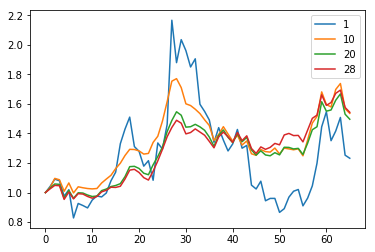

In [163]:
print('1 종목 수익률: {}'.format(yc['1'].iloc[-1] - yc['1'].iloc[0]))
print('10 종목 수익률: {}'.format(yc['10'].iloc[-1] - yc['10'].iloc[0]))
print('20 종목 수익률: {}'.format(yc['20'].iloc[-1] - yc['20'].iloc[0]))
print('28 종목 수익률: {}'.format(yc['28'].iloc[-1] - yc['28'].iloc[0]))
yc.plot()
plt.show()

1 종목 수익률: -0.3546150442607079
10 종목 수익률: 0.5976047913494165
20 종목 수익률: 0.5371633317371074
28 종목 수익률: 0.5690465517410261


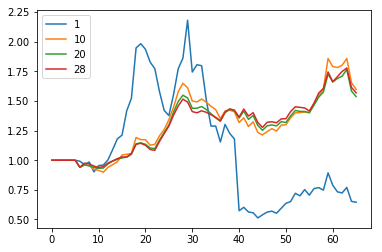

In [183]:
# 6달 수익률 기반 모멘텀 전략
ind_m_ret = industry_m.pct_change().fillna(0)
ind_6m_ret = (industry_m - industry_m.shift(6)) / industry_m.shift(6)
ind_6m_ret.fillna(0, inplace=True)
ind_rank = ind_6m_ret.T.rank(ascending=False).T

bt = pd.DataFrame()

for n in [1, 10, 20, 28]:
    return_history = []

    for i in range(len(ind_m_ret) - 1):
        ind_row = ind_rank.iloc[i]
        top_ind_index = ind_row[ind_row <= n].index

        date = i + 1
        ret_row = ind_m_ret.iloc[date]
        top_ind_ret = ret_row[top_ind_index]

        mean_ret = top_ind_ret.mean()
        return_history.append(mean_ret)

    bt[str(n)] = return_history

bt.fillna(0, inplace=True)
yc = (bt + 1).cumprod()

print('1 종목 수익률: {}'.format(yc['1'].iloc[-1] - yc['1'].iloc[0]))
print('10 종목 수익률: {}'.format(yc['10'].iloc[-1] - yc['10'].iloc[0]))
print('20 종목 수익률: {}'.format(yc['20'].iloc[-1] - yc['20'].iloc[0]))
print('28 종목 수익률: {}'.format(yc['28'].iloc[-1] - yc['28'].iloc[0]))
yc.plot()
plt.show()

1 종목 수익률: 0.2397637198726026
10 종목 수익률: 0.9332761348550946
20 종목 수익률: 0.7589333902480311
28 종목 수익률: 0.6236687789083457


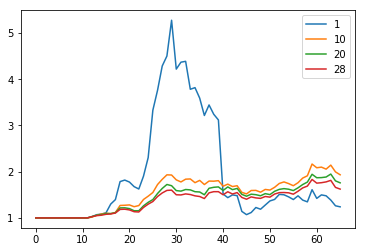

In [184]:
# 1년 수익률 기반 모멘텀 전략
ind_m_ret = industry_m.pct_change().fillna(0)
ind_12m_ret = (industry_m - industry_m.shift(12)) / industry_m.shift(12)
ind_12m_ret.fillna(0, inplace=True)
ind_rank = ind_12m_ret.T.rank(ascending=False).T

bt = pd.DataFrame()

for n in [1, 10, 20, 28]:
    return_history = []

    for i in range(len(ind_m_ret) - 1):
        ind_row = ind_rank.iloc[i]
        top_ind_index = ind_row[ind_row <= n].index

        date = i + 1
        ret_row = ind_m_ret.iloc[date]
        top_ind_ret = ret_row[top_ind_index]

        mean_ret = top_ind_ret.mean()
        return_history.append(mean_ret)

    bt[str(n)] = return_history

bt.fillna(0, inplace=True)
yc = (bt + 1).cumprod()

print('1 종목 수익률: {}'.format(yc['1'].iloc[-1] - yc['1'].iloc[0]))
print('10 종목 수익률: {}'.format(yc['10'].iloc[-1] - yc['10'].iloc[0]))
print('20 종목 수익률: {}'.format(yc['20'].iloc[-1] - yc['20'].iloc[0]))
print('28 종목 수익률: {}'.format(yc['28'].iloc[-1] - yc['28'].iloc[0]))
yc.plot()
plt.show()

#### 절대 모멘텀

하락장에서는 투자를 하지 않기 위해서 (모멘텀 전략의 단점) 모멘텀이 0 이상인 산업에는 투자하지 않는다.

In [211]:
ind_m_ret = industry_m.pct_change().fillna(0)

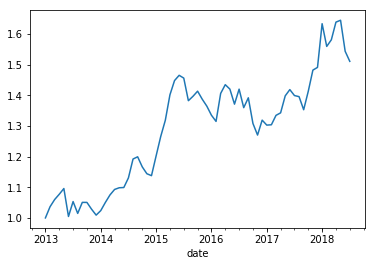

In [212]:
(ind_m_ret.T.mean().T + 1).cumprod().plot()
plt.show()

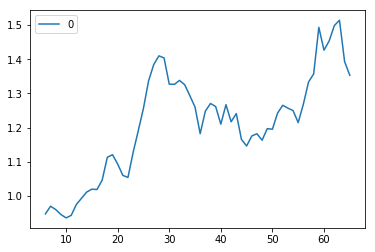

In [235]:
ind_6m_ret = (industry_m - industry_m.shift(6)) / industry_m.shift(6)
ind_6m_ret.fillna(0, inplace=True)

bt_history = []

for date in range(len(ind_m_ret.index) - 1):
    invest_date = date + 1
    
    row = ind_6m_ret.iloc[date]
    invest_ind = row[row > 0].index
    
    invest_row = ind_m_ret.iloc[invest_date][invest_ind]
    bt_history.append(invest_row.mean())
    
bt = pd.DataFrame(bt_history)
(bt + 1).cumprod().plot()
plt.show()

## 모든 기술을 조합하여 포트폴리오 운용하기

1. 저변동성: 주가의 변동성이 낮은
2. 저베타: 종합주가지수와 상관성이 낮은
3. 모멘텀: 주가 상승이 강한

포트폴리오 만들기

#### 포트폴리오를 만들고 리밸런싱하는 방법 기초

- 동일 비중 포트폴리오 전략